In [2]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import imageio
import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import scipy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical
import tensorflow

Using TensorFlow backend.


In [3]:
IMAGE_PATH = '../input/bee_imgs/bee_imgs/'
IMAGE_WIDTH = 100
IMAGE_HEIGHT = 100
IMAGE_CHANNELS = 3
RANDOM_STATE = 2018
TEST_SIZE = 0.2
VAL_SIZE = 0.2
CONV_2D_DIM_1 = 16
CONV_2D_DIM_2 = 16
CONV_2D_DIM_3 = 32
CONV_2D_DIM_4 = 64
MAX_POOL_DIM = 2
KERNEL_SIZE = 3
BATCH_SIZE = 32
NO_EPOCHS_1 = 5
NO_EPOCHS_2 = 10
NO_EPOCHS_3 = 50
PATIENCE = 5
VERBOSE = 1

In [4]:
os.listdir("../input")

['bee_imgs', 'bee_data.csv']

In [5]:
honey_bee_df=pd.read_csv('../input/bee_data.csv')

In [6]:
honey_bee_df.sample(100).head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
810,030_602.png,8/17/18,17:50,"Alvin, TX, USA",77511,Italian honey bee,ant problems,False,worker
766,030_167.png,8/17/18,17:50,"Alvin, TX, USA",77511,Italian honey bee,ant problems,False,worker
1669,040_039.png,8/21/18,15:56,"Athens, GA, USA",30607,Italian honey bee,"few varrao, hive beetles",False,worker
3026,043_001.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1341,005_561.png,7/7/18,12:56,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker


In [7]:
honey_bee_df.isnull().sum()

file               0
date               0
time               0
location           0
zip code           0
subspecies         0
health             0
pollen_carrying    0
caste              0
dtype: int64

In [8]:
tmp = honey_bee_df.groupby(['zip code'])['location'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df

,zip code,location,Images
0,3431,"Keene, NH, USA",92
1,30607,"Athens, GA, USA",579
2,30607,"Athens, Georgia, USA",472
3,50315,"Des Moines, IA, USA",973
4,70115,"New Orleans, LA, USA",170
5,77511,"Alvin, TX, USA",737
6,95070,"Saratoga, CA, USA",2000
7,95124,"San Jose, CA, USA",149


In [9]:
locations = (honey_bee_df.groupby(['location'])['location'].nunique()).index

In [10]:
def draw_category_images(var,cols=5):
    categories = (honey_bee_df.groupby([var])[var].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=cols, figsize=(2*cols,2*len(categories)))
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = honey_bee_df[honey_bee_df[var]==cat].sample(cols)
        for j in range(0,cols):
            file=IMAGE_PATH + sample.iloc[j]['file']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True)
            ax[i, j].set_title(cat, fontsize=9)  
    plt.tight_layout()
    plt.show()

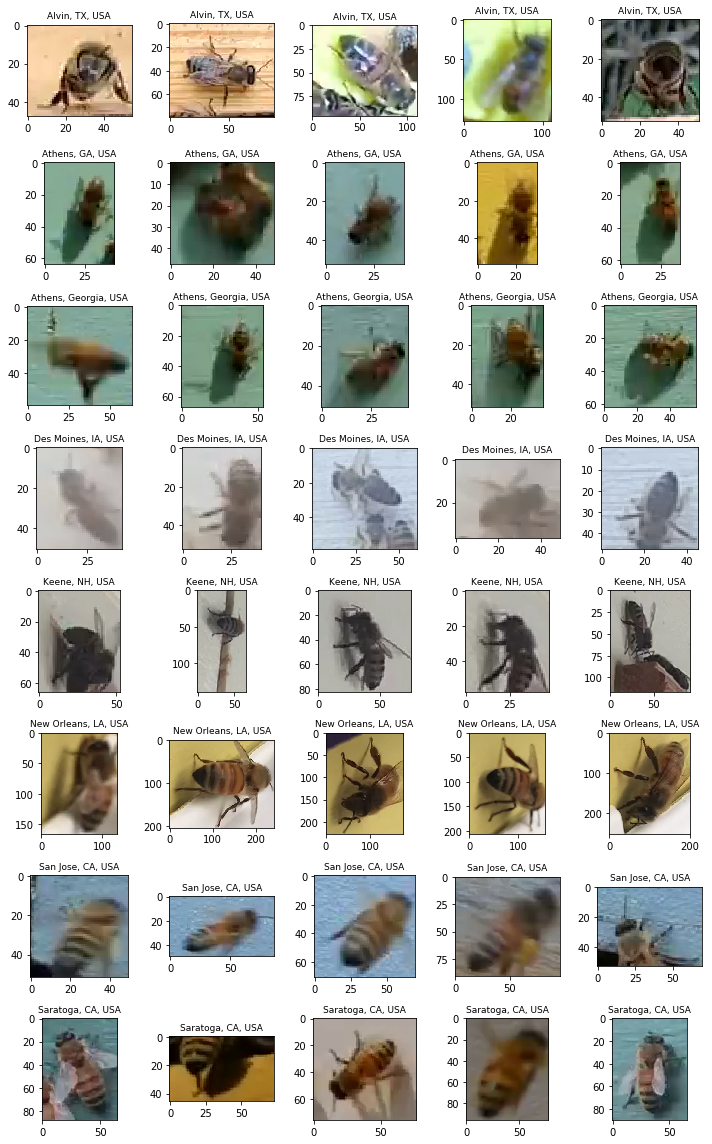

In [11]:
draw_category_images("location")

In [12]:
honey_bee_df['date_time'] = pd.to_datetime(honey_bee_df['date'] + ' ' + honey_bee_df['time'])
honey_bee_df["year"] = honey_bee_df['date_time'].dt.year
honey_bee_df["month"] = honey_bee_df['date_time'].dt.month
honey_bee_df["day"] = honey_bee_df['date_time'].dt.day
honey_bee_df["hour"] = honey_bee_df['date_time'].dt.hour
honey_bee_df["minute"] = honey_bee_df['date_time'].dt.minute

In [13]:
tmp = honey_bee_df.groupby(['subspecies'])['year'].value_counts()
df = pd.DataFrame(data={'Images': tmp.values}, index=tmp.index).reset_index()
df

,subspecies,year,Images
0,-1,2018,428
1,1 Mixed local stock 2,2018,472
2,Carniolan honey bee,2018,501
3,Italian honey bee,2018,3008
4,Russian honey bee,2018,527
5,VSH Italian honey bee,2018,199
6,Western honey bee,2018,37


In [14]:
train_df, test_df = train_test_split(honey_bee_df, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [15]:
train_df, val_df = train_test_split(train_df, test_size=VAL_SIZE, random_state=RANDOM_STATE)

In [16]:
print("Train set rows: {}".format(train_df.shape[0]))
print("Test  set rows: {}".format(test_df.shape[0]))
print("Val   set rows: {}".format(val_df.shape[0]))

Train set rows: 3309
Test  set rows: 1035
Val   set rows: 828


In [17]:
def read_image(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    image = skimage.transform.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), mode='reflect')
    return image[:,:,:IMAGE_CHANNELS]

In [18]:
def categories_encoder(dataset, var='subspecies'):
    X = np.stack(dataset['file'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

In [19]:
X_train, y_train = categories_encoder(train_df)
X_val, y_val = categories_encoder(val_df)
X_test, y_test = categories_encoder(test_df)

In [20]:
model1=Sequential()
model1.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model1.add(MaxPool2D(MAX_POOL_DIM))
model1.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model1.add(Flatten())
model1.add(Dense(y_train.columns.size, activation='softmax'))
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [21]:
image_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=180,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True,
        vertical_flip=True)
image_generator.fit(X_train)

In [22]:
train_model1  = model1.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_1,
                        validation_data=[X_val, y_val],
                        steps_per_epoch=len(X_train)/BATCH_SIZE)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
104/103 [==============================] - 22s 213ms/step - loss: 0.9075 - acc: 0.7096 - val_loss: 0.6767 - val_acc: 0.7657
Epoch 2/5
104/103 [==============================] - 21s 203ms/step - loss: 0.5486 - acc: 0.7903 - val_loss: 0.5392 - val_acc: 0.8056
Epoch 3/5
104/103 [==============================] - 21s 204ms/step - loss: 0.4643 - acc: 0.8092 - val_loss: 0.4531 - val_acc: 0.8128
Epoch 4/5
104/103 [==============================] - 21s 206ms/step - loss: 0.3748 - acc: 0.8400 - val_loss: 0.4147 - val_acc: 0.8309
Epoch 5/5
104/103 [==============================] - 22s 208ms/step - loss: 0.3611 - acc: 0.8438 - val_loss: 0.3850 - val_acc: 0.8539


In [23]:
score = model1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.35574255398506127
Test accuracy: 0.8579710144927536


In [24]:
model2=Sequential()
model2.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model2.add(MaxPool2D(MAX_POOL_DIM))
# Add dropouts to the model
model2.add(Dropout(0.4))
model2.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
# Add dropouts to the model
model2.add(Dropout(0.4))
model2.add(Flatten())
model2.add(Dense(y_train.columns.size, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [25]:
train_model2  = model2.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_2,
                        validation_data=[X_val, y_val],
                        steps_per_epoch=len(X_train)/BATCH_SIZE)

Epoch 1/10
104/103 [==============================] - 23s 223ms/step - loss: 1.1718 - acc: 0.6306 - val_loss: 1.0375 - val_acc: 0.6377
Epoch 2/10
104/103 [==============================] - 23s 219ms/step - loss: 0.7979 - acc: 0.6921 - val_loss: 0.7037 - val_acc: 0.7089
Epoch 3/10
104/103 [==============================] - 23s 220ms/step - loss: 0.5847 - acc: 0.7882 - val_loss: 0.5447 - val_acc: 0.8031
Epoch 4/10
104/103 [==============================] - 23s 219ms/step - loss: 0.4518 - acc: 0.8250 - val_loss: 0.4647 - val_acc: 0.8321
Epoch 5/10
104/103 [==============================] - 23s 222ms/step - loss: 0.4170 - acc: 0.8321 - val_loss: 0.4169 - val_acc: 0.8406
Epoch 6/10
104/103 [==============================] - 23s 219ms/step - loss: 0.4727 - acc: 0.8157 - val_loss: 0.3779 - val_acc: 0.8539
Epoch 7/10
104/103 [==============================] - 23s 223ms/step - loss: 0.3658 - acc: 0.8477 - val_loss: 0.3790 - val_acc: 0.8647
Epoch 8/10
104/103 [==============================] - 2

In [26]:
score = model2.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.276241703165902
Test accuracy: 0.8898550724637682


In [29]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 16)        2320      
_________________________________________________________________
flatten_1 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 280007    
Total params: 282,775
Trainable params: 282,775
Non-trainable params: 0
_________________________________________________________________


In [30]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 16)        2320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 50, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 280007    
Total para